#Machine learning using NLP

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [2]:


true_data = pd.read_csv('/content/True.csv')
fake_data = pd.read_csv('/content/Fake.csv')

print(true_data.shape)
print(fake_data.shape)


(21417, 4)
(23481, 4)


In [3]:
fake_data['label'] = 1
true_data['label'] = 0

In [4]:
df = pd.concat([true_data, fake_data]).reset_index(drop=True)

In [5]:
#df.head()

In [6]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [7]:
df.shape

(44898, 5)

In [8]:
df=df.drop(['title','subject','date'],axis=1)

In [9]:
#df.head()

In [10]:
df=df.sample(frac=1)

In [11]:
#df.head()

In [12]:
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [13]:
df.head()

,text,label
0,Tune in to the Alternate Current Radio Network...,1
1,"For some reason, Donald Trump decided to speak...",1
2,While we re so happy to hear that 3 innocent A...,1
3,21st Century Wire says Washington s Russian wi...,1
4,"170619-N-AA175-092..SAN DIEGO (June 19, 2017) ...",1


In [14]:
# import nltk
# nltk.download('stopwords')

# def preprocess(text):
#     text = re.sub('[^a-zA-Z]', ' ', text)  # remove punctuation
#     text = text.lower()
#     text = text.split()
#     ps = PorterStemmer()
#     text = [ps.stem(word) for word in text if word not in stopwords.words('english')]
#     return ' '.join(text)

# df['clean_text'] = df['text'].apply(preprocess)

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['text'] = df['text'].apply(clean_text)

In [16]:
x = df['text']
y = df['label']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [18]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [19]:
x_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1300851 stored elements and shape (8980, 179826)>

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train_tfidf, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(x_train_tfidf, y_train)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(x_train_tfidf, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(x_train_tfidf, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:47:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [22]:
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "Decision Tree": dt,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"📊 {name}")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 40)


📊 Logistic Regression
Accuracy: 0.9831
Confusion Matrix:
[[4188   80]
 [  72 4640]]
----------------------------------------
📊 Random Forest
Accuracy: 0.9840
Confusion Matrix:
[[4211   57]
 [  87 4625]]
----------------------------------------
📊 Decision Tree
Accuracy: 0.9964
Confusion Matrix:
[[4249   19]
 [  13 4699]]
----------------------------------------
📊 XGBoost
Accuracy: 0.9969
Confusion Matrix:
[[4256   12]
 [  16 4696]]
----------------------------------------


# XGBoost perform best

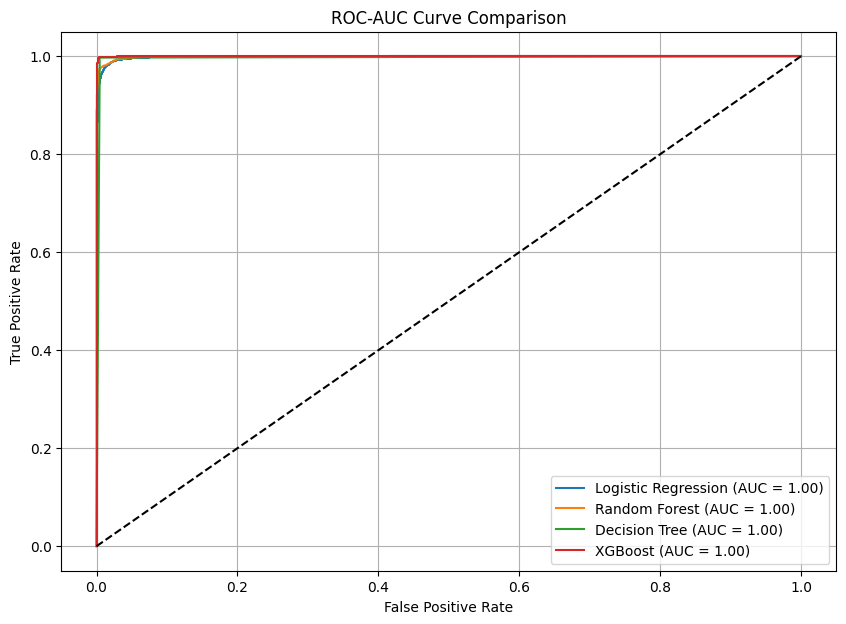

In [23]:
plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test_tfidf)[:, 1]
    else:
        y_prob = model.decision_function(x_test_tfidf)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import pickle

xgb_model = xgb
tfidf_vectorizer = tfidf

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
